# Assignment 4
Training a simple neural net for relation classification.

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn import metrics
!pip install transformers

In this assignment you are required to build a full training and testing pipeline for a neural relation classification (RC), using BERT.

The dataset that you will be working on is called SemEval Task 8 dataset (https://arxiv.org/pdf/1911.10422v1.pdf). The dataset contain only train and test split, but you are allowed to split the train dataset into dev if needed.


The two files (train and test) are available from the course git repository (https://github.com/kfirbar/nlp-course)


In this work we will use the hugingface framework for transformers training and inference. We recomand reading the documentation in https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification *before* you start coding. 


**Task 1:** Write a funtion *read_data* for reading the data from a single file (either train or test). This function recieves a filepath and returns a list of sentence. Every sentence is encoded as a touple, where the first element is the sentence string and the second the label (also represented as a sting). 

In [4]:
!git clone https://github.com/kfirbar/nlp-course

fatal: destination path 'nlp-course' already exists and is not an empty directory.


In [6]:
!ls nlp-course

connl03_dev.txt    lm-languages-data	  TEST_FILE_FULL.TXT
connl03_test.txt   lm-languages-data-new  TEST_FILE.txt
connl03_train.txt  README.md		  TRAIN_FILE.TXT


In [3]:
FIRST_ENTITY_START_TOKEN = '<e1>'
SECOND_ENTITY_START_TOKEN = '<e2>'
entities_tags = [FIRST_ENTITY_START_TOKEN, '</e1>', SECOND_ENTITY_START_TOKEN, '</e2>']

In [8]:
def read_data(filepath):
    data = []
    # TODO... write your code accordingly

    with open(filepath) as f:
        while True:         
            sentense = next(f, None)
            if sentense is None:
                break

            label = next(f)
            _ = next(f)
            _ = next(f)
            data.append((sentense.strip(), label.strip()))

    return data

train = read_data('/content/nlp-course/TRAIN_FILE.TXT')
test = read_data('/content/nlp-course/TEST_FILE.txt')


Pytorch require the labels to be integers. Create a mapper (dictionary) from the string labels to integers (starting zero). 

In [9]:
def create_label_mapper(data):
  # TODO... write your code accordingly 
  label_mapper = {}
  for _, label in data:
    if label not in label_mapper:
      label_mapper[label] = len(label_mapper)

  return label_mapper
  

label_mapper = create_label_mapper(train)
            

In [10]:
len(label_mapper), len(train)

(19, 8000)

**Task 2:** Write a function *prepare_data* that takes one of the [train, test] datasets and convert each pair of (words,labels) to a pair of indexes. The function also aggregate the samples into batches. BERT Uses pretrained tokanization and embedding. you can access the tokanization and indexing using the BertTokenizer class.

In [11]:
from transformers import BertTokenizer
import numpy as np

def prepare_data(data, tokenizer, batch_size=8, remove_entities_tags = False):
    data_sequences = []
    # TODO - your code...

    indexes = np.random.choice(range(0, len(data)), size = len(data) ,replace=False)
    
    current_batch_input = []
    current_batch_labels = []
    
    for i in range(0, len(indexes), batch_size): #index in indexes:
      curremt_indexes = indexes[i: i+ batch_size]
      batch_data = [data[i] for i in curremt_indexes]
      
      sentenses = [row[0] for row in batch_data]

      if remove_entities_tags:
        for entity_tag in entities_tags:
          sentenses = [sentense.replace(entity_tag, '') for sentense in sentenses]

      labels = torch.from_numpy(np.array([label_mapper[row[1]] for row in batch_data]))
      
      sentenses_ids = tokenizer.batch_encode_plus(sentenses, padding = 'longest', return_tensors='pt')['input_ids']
      
      data_sequences.append((sentenses_ids, labels))
    
    return data_sequences


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', padding = 'max_length', truncation=True, return_tensors='pt')

train_sequences = prepare_data(train, tokenizer, remove_entities_tags=True)
test_sequences = prepare_data(test, tokenizer)

In [12]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

**Task 3:** In this part we classify the sentences using the BertForSequenceClassification model. To save resources, we initialize the optimizer with the final layer of the model. You are also allowed to change the learning rate.

In [14]:
from transformers import BertForSequenceClassification

def get_parameters(params):
  # TODO - your code...
  fixed_params = []
  for name, param in params:
    if 'classifier' not in name:
      param.requires_grad = False
      
    fixed_params.append(param)

  return fixed_params

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_mapper)).to(device)
# Optimizer (ADAM is a fancy version of SGD)
optimizer = torch.optim.Adam(get_parameters(model.named_parameters()), lr=0.001)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

**Task 4:** Write a training loop, which takes a BertForSequenceClassification model and number of epochs to train on. The loss is always CrossEntropyLoss and the optimizer is always Adam. You are allowed to split the train to train and dev sets.

In [15]:
from torch.autograd import Variable

def train_loop(model, n_epochs, train_data, dev_data):
  # Loss function
  model.train()
  criterion = nn.CrossEntropyLoss()
 
  for e in range(1, n_epochs + 1):
    batch_loss = 0.0 
    for sentenses, labels in train_data:
      sentenses = Variable(sentenses).to(device)
      labels = Variable(labels).to(device)

      logits = model(sentenses).logits
      loss = criterion(logits, labels)

      batch_loss += loss.item()

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
    print('batch {} loss {}'.format(e, batch_loss/len(train_data)))



train_loop(model,100, train_sequences, None)


batch 1 loss 2.7252868176698684
batch 2 loss 2.6529804565906523
batch 3 loss 2.6093166794776916
batch 4 loss 2.579661792397499
batch 5 loss 2.555987601518631
batch 6 loss 2.526829599738121
batch 7 loss 2.5162516382932663
batch 8 loss 2.4980180265903473
batch 9 loss 2.495340171933174
batch 10 loss 2.472457421541214
batch 11 loss 2.461961941957474
batch 12 loss 2.4551534428596495
batch 13 loss 2.4473064217567444
batch 14 loss 2.4461438789367675
batch 15 loss 2.447845650434494
batch 16 loss 2.4281981382369997
batch 17 loss 2.4306584664583206
batch 18 loss 2.4173237013816835
batch 19 loss 2.4159244536161424
batch 20 loss 2.4154026554822923


KeyboardInterrupt: ignored

**Task 5:** write an evaluation loop on a trained model, using the dev and test datasets. This function print the true positive rate (TPR), also known as Recall and the opposite to false positive rate (FPR), also known as precision, of each label seperately (10 labels in total), and for all labels together. The caption argument for the function should be served for printing, so that when you print include it as a prefix.

In [16]:
def evaluate(model, test_data):
  # TODO - your code goes here
  model.eval()
  all_predictions = []
  all_labels = []
  with torch.no_grad():
    for sentenses, labels in test_data:
      sentenses = Variable(sentenses).to(device)
      labels = labels.numpy()

      logits = model(sentenses).logits

      prediction = torch.argmax(logits, 1).cpu().detach().numpy()

      all_labels.extend(labels.tolist())
      all_predictions.extend(prediction.tolist())

    print(metrics.classification_report(all_labels, all_predictions, digits=3))
      

evaluate(model, test_sequences)

              precision    recall  f1-score   support

           0      0.517     0.132     0.210       471
           1      0.211     0.570     0.308      1410
           2      0.500     0.002     0.005       407
           3      0.000     0.000     0.000        78
           4      0.667     0.067     0.121       659
           5      0.441     0.386     0.412       844
           6      0.805     0.088     0.159       374
           7      0.207     0.686     0.318       490
           8      0.292     0.018     0.033       394
           9      0.367     0.348     0.357       612
          10      0.262     0.116     0.161       568
          11      0.429     0.017     0.034       344
          12      0.315     0.198     0.243       470
          13      0.000     0.000     0.000       144
          14      0.000     0.000     0.000       323
          15      0.318     0.500     0.388       148
          16      0.206     0.265     0.232       166
          17      0.000    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Task 6:** In this part we'll improve the model accuracy by using a method called "entity markers - Entity start". The main idea of this approch is to add special markers ([e1], [\e1], ...) before and after each of the tagged entities. instead of using the CLS toekn for clasification, we will use the concatination of the embedding of [e1] and [e2] as shown in the image below. The complete method is described in details in the following paper - https://arxiv.org/pdf/1906.03158.pdf (specifically in Section 3.2). To use this method we'll need to create a new data load and a new model.

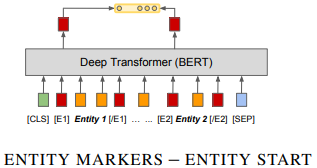

The new methods require the usage of special tokens. The following code will add the required tokens.

In [17]:
tokenizer.add_tokens(entities_tags)
first_entity_start_token_id, second_entity_start_token_id = tokenizer.convert_tokens_to_ids([FIRST_ENTITY_START_TOKEN, SECOND_ENTITY_START_TOKEN])
first_entity_start_token_id, second_entity_start_token_id


(30522, 30524)

Create a new dataloader that add entity markers to the dataset and return their indexes as part of the new sample (the expected sample should be (s, l, i) where s is the sentence embedding, l is the label, and i is a touple with the indexes of the start entities)

In [18]:
def prepare_data_MTB(data, tokenizer, batch_size=8):
    data_sequences = []
    # TODO - your code...

    indexes = np.random.choice(range(0, len(data)), size = len(data) ,replace=False)
    
    current_batch_input = []
    current_batch_labels = []
    
    for i in range(0, len(indexes), batch_size): #index in indexes:
      curremt_indexes = indexes[i: i+ batch_size]
      batch_data = [data[i] for i in curremt_indexes]
      
      sentenses = [row[0] for row in batch_data]

      labels = torch.from_numpy(np.array([label_mapper[row[1]] for row in batch_data]))
      
      sentenses_ids = tokenizer.batch_encode_plus(sentenses, padding = 'longest', return_tensors='pt')['input_ids']
      
      
      first_second_entites_start_locations = [(sentense_ids.numpy().tolist().index(first_entity_start_token_id), sentense_ids.numpy().tolist().index(second_entity_start_token_id)) for sentense_ids in sentenses_ids]
        
      data_sequences.append((sentenses_ids, labels, first_second_entites_start_locations))
    
    return data_sequences


train_sequences = prepare_data_MTB(train, tokenizer)
test_sequences = prepare_data_MTB(test, tokenizer)

Create a new model that uses the "entity markers - Entity start" method.

In [19]:
from transformers import AutoConfig, AutoModel

class MTB(nn.Module):
    def __init__(self, base_model_name):
      nn.Module.__init__(self)
      config = AutoConfig.from_pretrained(base_model_name)
      config.output_hidden_states = True
      self.model = AutoModel.from_config(config)
      self.model.resize_token_embeddings(len(tokenizer))
      for _, param in self.model.named_parameters():
        param.requires_grad = False
      
      self.fc2 = nn.Linear(1536, len(label_mapper))

      # TODO - your code...
    def forward(self, input, index):
      # TODO - your code...
      bert_embeddings = self.model(input).hidden_states[0]

      start_embeddings = torch.zeros(size = (input.shape[0], 768)).to(device)
      end_embeddings = torch.zeros(size = (input.shape[0], 768)).to(device)

      for row_index, (start_index, end_index) in enumerate(index):
        start_embeddings[row_index] =  bert_embeddings[row_index][start_index]
        end_embeddings[row_index] =  bert_embeddings[row_index][end_index]
      
      start_end_embedding = torch.cat((start_embeddings, end_embeddings), 1)

      return self.fc2(start_end_embedding)

model = MTB('bert-base-uncased').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [22]:
def train_loop(model, n_epochs, train_data):
  # Loss function
  model.train()
  criterion = nn.CrossEntropyLoss()
 
  for e in range(1, n_epochs + 1):
    batch_loss = 0.0 
    for sentenses, labels, indexes in train_data:
      sentenses = Variable(sentenses).to(device)
      labels = Variable(labels).to(device)

      logits = model(sentenses, indexes)
      loss = criterion(logits, labels)

      batch_loss += loss.item()

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
     
      
    
    print('batch {} loss {}'.format(e, batch_loss/len(train_data)))
  


In [21]:
def evaluate(model, test_data):

  model.eval()
  all_predictions = []
  all_labels = []
  with torch.no_grad():
    for sentenses, labels, indexes in test_data:
      sentenses = Variable(sentenses).to(device)
      labels = labels.numpy()

      logits = model(sentenses, indexes)

      prediction = torch.argmax(logits, 1).cpu().detach().numpy()

      all_labels.extend(labels.tolist())
      all_predictions.extend(prediction.tolist())

  print(metrics.classification_report(all_labels, all_predictions, digits=3))

Use the new dataloader and model to train and evaluate the new model as in task 4 and 5

In [ ]:
train_loop(model, 100, train_sequences)

In [ ]:
evaluate(model, test_sequences)

**Good luck!**